# IIC-2433 Minería de Datos UC

- Versiones de librerías, python 3.8.10

- numpy 1.20.3
- sklearn 1.0.2
- matplotlib 3.5.2

In [25]:
from sklearn import datasets

faces = datasets.fetch_olivetti_faces()
X = faces.data
y = faces.target
print(X.data.shape)

(400, 4096)


## Actividad en clase

Vamos a visualizar este dataset usando **t-SNE** y **UMAP**. Para esto haga lo siguiente:

- Aplique min-max scaler al dataset.
- Transforme el dataset con PCA para retener el 95% de la varianza.
- Use LOF con k=5 y obtenga el histograma de puntajes LOF. Defina un umbral de corte. 
- Obtenga para el umbral de corte definido los inliers/outliers. 
- Elimine los outliers del dataset. 
- Sobre el dataset limpio, construya una proyección **t-SNE**. Justifique la elección de parámetros.
- Visualice su proyección usando los códigos vistos en clase. Modifíquelos para que funcionen sobre este dataset.
- Sobre el dataset limpio, construya una proyección **UMAP**. Justifique la elección de parámetros.
- Visualice su proyección usando los códigos vistos en clase. 
- ¿Qué puede identificar en estas visualizaciones? 
- Cuanto termine, me avisa para entregarle una **L (logrado)**.
- Recuerde que las L otorgan un bono en la nota final de la asignatura.
- Pueden trabajar de a dos.

***Tiene hasta el final de la clase.***

### Aplicamos MinMaxScaler

In [26]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

### Descomponemos a 400

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=400)
pca.fit(X)

PCA(n_components=400)

### Calculamos cuántas componentes retienen el 95% de la varianza

In [28]:
def min_var(v,exp_var):
    acc = 0
    i=0
    while acc < v:
        acc += exp_var[i]
        i += 1
    return i


## Calculamos las compoenntes para retener el 90% de la varianza del dataset original
min_var(0.95,pca.explained_variance_ratio_)

121

### Proyectamos usando PCA a k = 121

In [29]:
pca = PCA(n_components=121)
X_= pca.fit_transform(X)

### Calculamos los puntajes LOF

In [30]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean')
lof.fit_predict(X_)
scores = lof.negative_outlier_factor_

### Dibujamos el histograma LOF

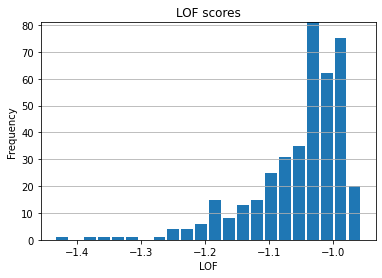

In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_hist(X, title):
    x, bins, patches = plt.hist(x=X, bins='auto', rwidth=0.85)
    plt.grid(axis='y')
    plt.xlabel('LOF')
    plt.ylabel('Frequency')
    plt.title(title)
    maxfreq = x.max()
    plt.ylim(ymax=np.ceil(maxfreq))


plot_hist(scores, 'LOF scores')

### Corto en un valor (yo usaré -1.3)

In [32]:
def lof_threshold(v,scores):
    N = len(scores)
    points = scores[scores < v]
    threshold = len(points)/N
    return threshold

lof_threshold(-1.3,scores)

0.0125

### El valor escogido me da un 0.0125 de datos outliers (es decir, el 1.25% de la muestra). Uso este valor para obtener sus posiciones en el dataset y removerlos

In [33]:
lof = LocalOutlierFactor(n_neighbors=5, metric='euclidean', contamination=0.0125)
labels = lof.fit_predict(X_)
indices = list(np.where(labels==1)[0])
X = X_[indices,:] 
y = y[indices,]

### Removí 5 ejemplos

In [34]:
X.shape

(395, 121)

### Voy a modificar el codigo para dibujar. Lo más importante es usar los target_names, que en este caso son los IDs de las personas

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import offsetbox

faces['target_names'] = np.unique(faces.target) # esto es nuevo

def plot_face_embedding(X, title):
    _, ax = plt.subplots(figsize=(12, 12))
    X = MinMaxScaler().fit_transform(X)

    for face in faces.target_names: # aquí los uso
        ax.scatter(
            *X[y == face].T,
            marker=f"${face}$", # en lugar de usar digit uso face (ID)
            color=plt.cm.Dark2(face),
            alpha=0.425, # The alpha blending value, between 0 (transparent) and 1 (opaque)
        )
    shown_images = np.array([[1.0, 1.0]])  # just something big
    for i in range(X.shape[0]):
        # plot every face on the embedding
        # show an annotation box for a group of faces
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 9e-3:   # aquí hay que calibrar!!!
            # don't show points that are too close
            continue
        shown_images = np.concatenate([shown_images, [X[i]]], axis=0)
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(faces.images[i], cmap=plt.cm.gray_r), X[i] 
        ) # Container referring to a specific position xy defined by X[i]
        imagebox.set()
        ax.add_artist(imagebox)

    ax.set_title(title)
    ax.axis("off")

### Como hay diez ejemplos por clase, voy a usar ese valor para perplexity

c:\Users\LarryUribe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\LarryUribe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


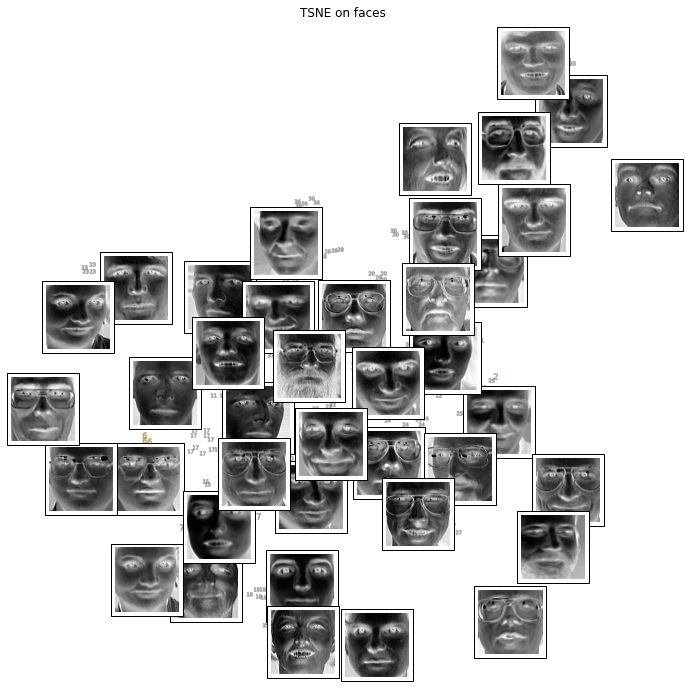

In [36]:
from sklearn.manifold import TSNE

tsne_embed_faces = TSNE(n_components=2, perplexity = 10, n_iter=5000, n_iter_without_progress=150, n_jobs=10)
projection = tsne_embed_faces.fit_transform(X, y)
plot_face_embedding(projection, 'TSNE on faces')
plt.show()

### Lo mismo para n_neighbors. Uso el valor esperado de ejemplos de la misma clase. En cuanto a min_dist, debe calibrarlo.

In [37]:
!pip install umap-learn

In [38]:
import umap.umap_ as umap

umap_2d = umap.UMAP(n_components = 2, min_dist = 0.05, n_neighbors= 10, n_jobs=10)
projection = umap_2d.fit_transform(X)
plot_face_embedding(projection, 'UMAP on faces')
plt.show()

ModuleNotFoundError: No module named 'umap.umap_'